# SHARP Analysis for Random Forest

### Introduction

You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where could you use this?

- A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
- A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions

You'll use SHAP Values to explain individual predictions. 

### How They Work

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c


### Implementation in Python Sklearn

Here is a simple implementation of those two methods explained above in Python Sklearn using Titanic dataset.

In [1]:
# Read files
#import os

# Data wrangling and data visualisation 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

# Others
import time
#import warnings
#warnings.filterwarnings("ignore")

### Import and Load Data

In [2]:
# Read data from the file
data = pd.read_csv("Titanic_train.csv")
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Feature engineering and preprocessing

- Fill missing data in the **Age** column with average age
- Combine **SibSp** and **Parch** features into a single feature: **family_size**
- Create indicator for missing data in the **Cabin** column: **cabin_missing**
- Encode the **Sex** column by assigning 0: male and 1: female
- Drop **SibSp, Parch, PassengerId, Cabin, Embarked, Name** and **Ticket** columns
- Train test split (80% training set and 20% test set)

In [3]:
# Missing data 
total = len(data)
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data
pd.DataFrame({"# Missing": missing_data, "% Missing": round(missing_data / len(data) * 100, 2)})

,# Missing,% Missing
Age,177,19.87
Cabin,687,77.10
Embarked,2,0.22


In [4]:
# Fill missing data in Age column
data['Age'].fillna(data['Age'].mean(), inplace = True)

In [5]:
# Missing data 
total = len(data)
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data
pd.DataFrame({"# Missing": missing_data, "% Missing": round(missing_data / len(data) * 100, 2)})

,# Missing,% Missing
Cabin,687,77.10
Embarked,2,0.22


<Figure size 432x288 with 0 Axes>

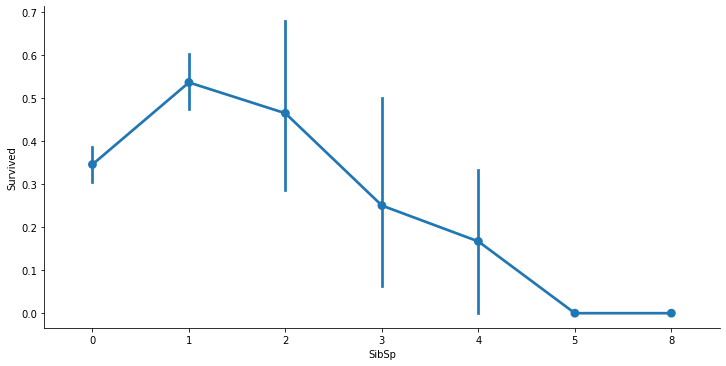

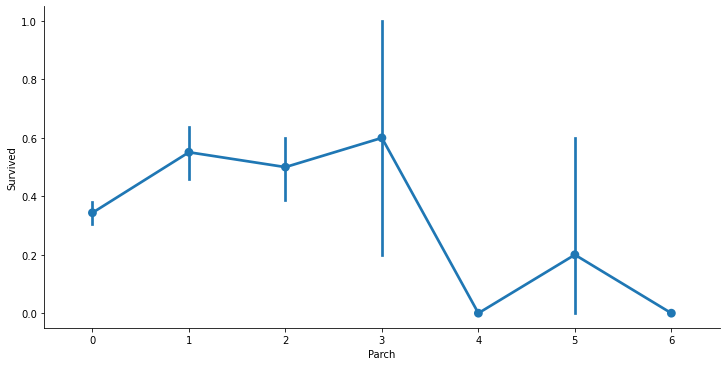

In [6]:
# Survival probability by SibSp and Parch 
# SibSp is the number of siblings or spouse of a person onboard.
# SibSp is the number of parents or children each passenger was touring with
for i, col in enumerate(['SibSp', 'Parch']):
    plt.figure(i)
    sns.catplot(x = col, y = 'Survived', data = data, kind = 'point', aspect = 2)

In [7]:
# Combine SibSp and Parch into a single feature family_size 
data['family_size'] = data['SibSp'] + data['Parch']
data[['SibSp', 'Parch', 'family_size']].head(10)

,SibSp,Parch,family_size
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0
5,0,0,0
6,0,0,0
7,3,1,4
8,0,2,2
9,1,0,1


To prevent multicollinearity issues, we need to remove SibSp and Parch features.

In [8]:
# Drop SibSp, Parch and PassengerId features
data = data.drop(['SibSp', 'Parch', 'PassengerId'], axis = 1)
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [9]:
# 1: Cabin is missing, 0: Cabin is not missing 
data['cabin_missing'] = np.where(data['Cabin'].isnull(), 1, 0)
data[['Cabin', 'cabin_missing']].head()

,Cabin,cabin_missing
0,NaN,1
1,C85,0
2,NaN,1
3,C123,0
4,NaN,1


In [10]:
# Encode Sex 0: male, 1: female
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size,cabin_missing
0,0,3,"Braund, Mr. Owen Harris",0,22.0,A/5 21171,7.2500,NaN,S,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,PC 17599,71.2833,C85,C,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,113803,53.1000,C123,S,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,373450,8.0500,NaN,S,0,1


In [11]:
# Drop Cabin, Embarked, Name and Ticket columns
data = data.drop(['Cabin', 'Embarked', 'Name', 'Ticket'], axis = 1)
data.head()

,Survived,Pclass,Sex,Age,Fare,family_size,cabin_missing
0,0,3,0,22.0,7.2500,1,1
1,1,1,1,38.0,71.2833,1,0
2,1,3,1,26.0,7.9250,0,1
3,1,1,1,35.0,53.1000,1,0
4,0,3,0,35.0,8.0500,0,1


In [12]:
# Separate features and target variables
features = data.drop('Survived', axis = 1)
target = data['Survived']

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

# Check shape (rows, columns)
print(f"Original data: {data.shape}")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

Original data: (891, 7)
X_train: (712, 6)
Y_train: (712,)
X_test: (179, 6)
Y_test: (179,)


### Random Forest

Default hyperparameters for RandomForestClassifier 

`RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
)`

In [13]:
# GridSearchCV for RandomForestClassifier
rf = RandomForestClassifier(n_jobs = -1, random_state = 10)
params = {
            'n_estimators': [5, 50, 250],
            'max_depth': [2, 4, 8, 16, 32, None]
        }

cv = GridSearchCV(rf, params, cv = 5, n_jobs = -1)
cv.fit(X_train, Y_train)
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.166599,0.038693,0.066000,0.011983,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.832168,0.846154,0.816901,0.802817,0.845070,0.828622,0.016696,1
6,0.038799,0.008930,0.018601,0.004841,8,5,"{'max_depth': 8, 'n_estimators': 5}",0.818182,0.839161,0.802817,0.838028,0.823944,0.824426,0.013478,2
7,0.185200,0.031155,0.060200,0.038437,8,50,"{'max_depth': 8, 'n_estimators': 50}",0.832168,0.825175,0.795775,0.816901,0.845070,0.823018,0.016458,3
8,0.694801,0.035369,0.069399,0.004963,8,250,"{'max_depth': 8, 'n_estimators': 250}",0.825175,0.825175,0.802817,0.809859,0.830986,0.818802,0.010632,4
10,0.224400,0.093250,0.043200,0.014497,16,50,"{'max_depth': 16, 'n_estimators': 50}",0.825175,0.797203,0.795775,0.823944,0.838028,0.816025,0.016703,5


In [14]:
# Best hyperparameters for RandomForestClassifier 
cv.best_params_

{'max_depth': 4, 'n_estimators': 50}

In [15]:
# Instantiate RandomForestClassifier with best hyperparameters 
rf = RandomForestClassifier(n_estimators = 50, max_depth = 4, n_jobs = -1, random_state = 42)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Fit time: 0.076 / Predict time: 0.012
Precision: 0.797 / Recall: 0.689 / Accuracy: 0.799


<AxesSubplot:>

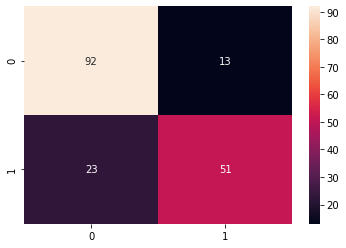

In [16]:
# Confusion matrix for RandomForestClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

In [23]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

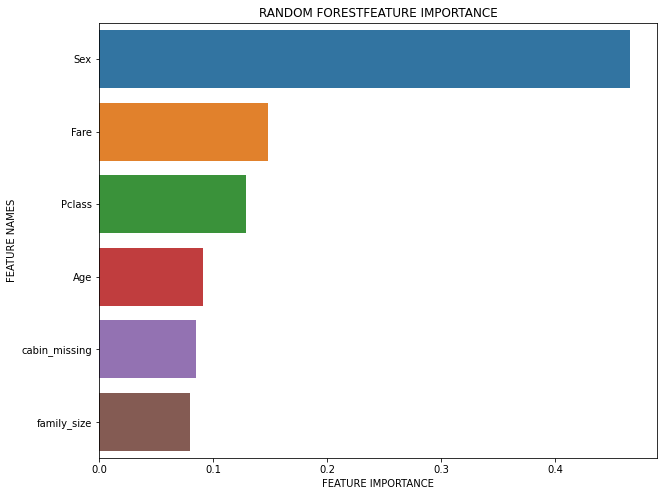

In [24]:
plot_feature_importance(rf.feature_importances_, X_train.columns,'RANDOM FOREST')

### SHARP Analysis¶


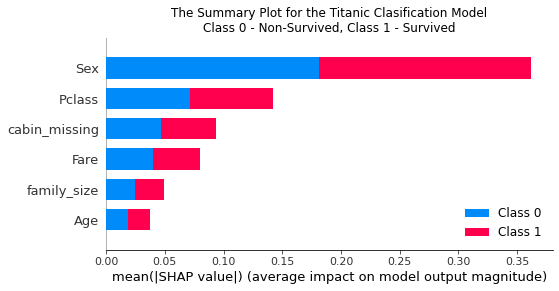

In [25]:
import shap # labirary for SHAP analysis

explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_test, approximate=True)

plt.title('The Summary Plot for the Titanic Clasification Model'+'\n'+'Class 0 - Non-Survived, Class 1 - Survived')

shap.summary_plot(shap_values, X_test, plot_type="bar")

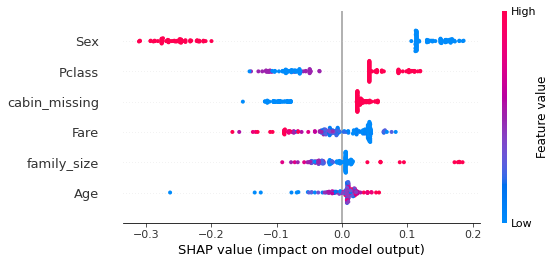

In [19]:
# Make plot. Index of [0] is explained in text below.
shap.summary_plot(shap_values[0], X_test)

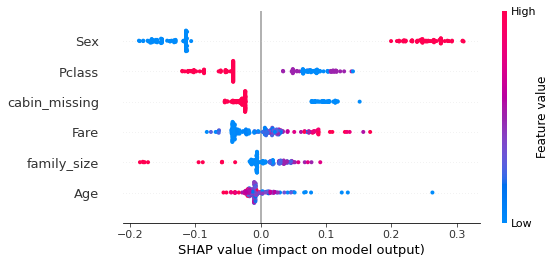

In [20]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)

This plot is made of many dots. Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.